### Using the model for predictions until 2072

In [1]:
""" Import packages """
import os
from datetime import datetime
import pickle
import sys
import logging
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '../scripts/')

logging.basicConfig(filename='../logs/modeling.log', filemode='a',
                    encoding='utf-8', level=logging.DEBUG)

warnings.filterwarnings("ignore")

from keras.models import load_model

2023-09-29 21:28:57.685827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 21:29:00.257034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from explorer import DataTransformer
from utils_cleaner import DataFrameCleaner
from utils_plots import EDAPlots

transformer = DataTransformer() 
plotmaker = EDAPlots()

In [3]:
from predictions import predict_next_year, predict_to_2070

In [4]:
REPO = "../"
filepath = "data/cleaned/study_dataset.csv"
rev = "Cleaneddatav22mf"

### Import the data

In [5]:
data = transformer.load_data(ext="csv", filepath=filepath, repo=REPO, rev=rev, header=0, parse_dates=["Date"])
data.head()

,ISO3,Date,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Feature_1,...,Feature_14,Feature_17,Feature_19,Feature_22,Feature_24,Feature_27,Feature_31,Feature_32,Feature_33,Feature_34
0,BFA,2000-12-31,603.210999,235.128065,874.845987,25.571181,62.627879,450.176799,717.149334,2.55,...,0.098126,856.4,26.376096,178.7,2.983886,85.40,6.857565,0,0,0
1,BFA,2001-12-31,601.937744,256.009859,918.916428,27.686540,66.619251,469.845175,876.388458,2.97,...,0.087891,967.8,26.193348,174.7,3.040729,85.49,6.867020,0,0,0
2,BFA,2002-12-31,595.852051,260.730606,958.846796,29.485652,72.230232,505.134949,743.621255,2.90,...,0.083175,942.7,26.010599,170.2,3.074790,85.43,6.874386,0,0,0
3,BFA,2003-12-31,585.123291,271.081041,965.412955,29.644367,72.615529,508.274478,881.413820,2.60,...,0.081205,996.3,25.827851,165.0,3.104518,85.30,6.865103,0,0,0
4,BFA,2004-12-31,562.411316,264.250419,925.186169,27.621911,71.165711,498.971133,873.945620,3.00,...,0.077845,940.7,25.645102,159.1,3.138021,85.31,6.873132,0,0,0


In [6]:
data.tail()

,ISO3,Date,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Feature_1,...,Feature_14,Feature_17,Feature_19,Feature_22,Feature_24,Feature_27,Feature_31,Feature_32,Feature_33,Feature_34
110,NGA,2018-12-31,299.020599,111.331623,290.249436,15.706434,34.044839,202.863325,463.932731,50.420000,...,0.109894,1687.700000,24.104384,119.600000,2.496645,81.640000,4.148946,0,0,0
111,NGA,2019-12-31,300.442535,112.336606,285.296699,15.739425,34.695950,205.938471,472.024294,47.980000,...,0.111119,1651.700000,23.925085,116.800000,2.448201,80.810000,4.050190,0,0,0
112,NGA,2020-12-31,313.758087,110.622612,275.291091,15.494435,34.225474,203.268430,481.044385,44.590000,...,0.104623,1666.900000,23.745787,113.800000,2.440609,82.510000,3.994245,0,0,0
113,NGA,2021-12-31,309.839005,108.934770,265.636388,15.253260,33.761378,200.633007,490.236844,51.010000,...,0.099462,1636.600000,23.594511,110.800000,2.406363,82.356371,3.911588,0,0,0
114,NGA,2022-12-31,305.968876,107.272681,256.320284,15.015838,33.303575,198.031753,499.604965,61.766261,...,0.094556,1667.023817,23.444199,108.321836,2.380007,82.203028,3.838623,0,0,0


### Split the data in subframes corresponding to each country

In [7]:
datacleaner = DataFrameCleaner(data)
bfa, gha, ken, mwi, nga = datacleaner.split_in_subframes("ISO3")

### Import the model

In [8]:
model = load_model('../models/LSTM_MBIOST/Time_lag_2/20230921_150200/20230921_150200/models/lstm_20230921_150200.h5')

2023-09-29 21:29:16.495840: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
scores_file = '../models/LSTM_MBIOST/Time_lag_2/20230921_150200/lstm_scores_20230921_150200.pkl'
with open(scores_file, 'rb') as f:
    actefacts = pickle.load(f)

In [10]:
scaler_inputs, scaler_targets = actefacts['scalers']

In [11]:
index_cols = ["ISO3", "Date"]
target_columns = [col for col in data.columns if col.startswith("Target")]
input_columns = [col for col in data.columns if col.startswith("Feature")] + target_columns
feature_columns = [col for col in data.columns if col.startswith("Feature")]

In [12]:
seq_length = 2

### Predictions for 2023 for each country

In [13]:
# Make predictions for each country (assuming data is already preprocessed)
pred_2023 = predict_next_year(
    model=model,
    end_year=2022,
    data=data, 
    group="ISO3",
    seq_length=2, 
    scaler_inputs=scaler_inputs,
    scaler_targets=scaler_targets,
    input_columns=input_columns,
    target_columns=target_columns
)

1/1 [==============================] - 3s 3s/step
Predictions for BFA in 2023:


,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2023-12-31,285.809753,103.245811,355.803101,10.010192,30.39369,187.943146,415.832794


1/1 [==============================] - 0s 47ms/step
Predictions for GHA in 2023:


,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2023-12-31,223.026962,77.52578,256.290039,11.444559,23.602839,137.884048,284.335785


1/1 [==============================] - 0s 53ms/step
Predictions for KEN in 2023:


,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2023-12-31,68.595078,12.489235,54.314049,3.279838,3.044881,17.61322,44.861351


1/1 [==============================] - 0s 41ms/step
Predictions for MWI in 2023:


,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2023-12-31,193.012878,35.896088,138.037033,7.958253,9.603265,61.123108,98.610497


1/1 [==============================] - 0s 41ms/step
Predictions for NGA in 2023:


,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2023-12-31,286.205353,107.872208,361.145355,16.062729,32.559647,191.335083,378.059998


#### Analyse of the predictions

In [14]:
print("Case of BFA")
display(pd.concat([bfa.set_index("Date")[target_columns].tail(1), (pred_2023["BFA"])]).pct_change())
display(pd.concat([bfa.loc[bfa.Date == "2019-12-31", ["Date"] + target_columns].set_index("Date"), (pred_2023["BFA"])]).pct_change())

Case of BFA


,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31,-0.238655,-0.107525,-0.02996,0.036931,-0.041903,-0.093222,-0.143804


,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31,-0.219273,-0.176653,-0.122186,-0.071826,-0.111598,-0.168659,-0.167018


In [15]:
print("Case of GHA")
display(pd.concat([gha.set_index("Date")[target_columns].tail(1), (pred_2023["GHA"])]).pct_change())
display(pd.concat([gha.loc[gha.Date == "2019-12-31", ["Date"] + target_columns].set_index("Date"), (pred_2023["GHA"])]).pct_change())

Case of GHA


,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31,0.491949,-0.001491,0.087493,0.130557,-0.072689,0.000509,-0.069545


,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31,0.38113,-0.047496,0.006392,0.075525,-0.107961,-0.043275,-0.065629


In [16]:
print("Case of KEN")
display(pd.concat([ken.set_index("Date")[target_columns].tail(1), (pred_2023["KEN"])]).pct_change())
display(pd.concat([ken.loc[ken.Date == "2019-12-31", ["Date"] + target_columns].set_index("Date"), (pred_2023["KEN"])]).pct_change())

Case of KEN


,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31,0.520888,-0.302599,-0.219676,-0.251823,-0.369917,-0.383599,-0.175692


,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31,0.21512,-0.306195,-0.245395,-0.257617,-0.365356,-0.382189,-0.096211


In [17]:
print("Case of MWI")
display(pd.concat([mwi.set_index("Date")[target_columns].tail(1), (pred_2023["MWI"])]).pct_change())
display(pd.concat([mwi.loc[mwi.Date == "2019-12-31", ["Date"] + target_columns].set_index("Date"), (pred_2023["MWI"])]).pct_change())

Case of MWI

,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31,-0.101766,-0.071244,0.051062,-0.170316,-0.147122,-0.10417,-0.222097


,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31,-0.062464,-0.180817,-0.105381,-0.26854,-0.236377,-0.199132,-0.262836


In [18]:
print("Case of NGA")
display(pd.concat([nga.set_index("Date")[target_columns].tail(1), (pred_2023["NGA"])]).pct_change())
display(pd.concat([nga.loc[nga.Date == "2019-12-31", ["Date"] + target_columns].set_index("Date"), (pred_2023["NGA"])]).pct_change())

Case of NGA


,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31,-0.064593,0.005589,0.408961,0.069719,-0.022338,-0.033816,-0.243282


,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31,-0.047387,-0.039741,0.265859,0.020541,-0.061572,-0.070911,-0.199067


### Predictions from 2023 to 2070

### Burkina Faso

In [19]:
bfa_pred = predict_to_2070(
    model=model,
    data=bfa, 
    seq_length=2, 
    scaler_inputs=scaler_inputs,
    scaler_targets=scaler_targets,
    input_columns=input_columns,
    target_columns=target_columns,
    feature_columns=feature_columns
)

1/1 [==============================] - 0s 48ms/step


In [20]:
targets_dict = {
    "Target_1": "Malaria Cases (per 1000)",
    "Target_2": "Malaria Deaths (per 1000)",
    "Target_3": "Malaria Deaths <5 Years Old (per 1000)",
    "Target_4": "Malaria Deaths 5-14 Years Old (per 1000)",
    "Target_5": "Malaria Deaths 15-49 Years Old (per 1000)",
    "Target_6": "Malaria Deaths 50-69 Years Old (per 1000)",
    "Target_7": "Malaria Deaths 70+ Years Old (per 1000)"
}

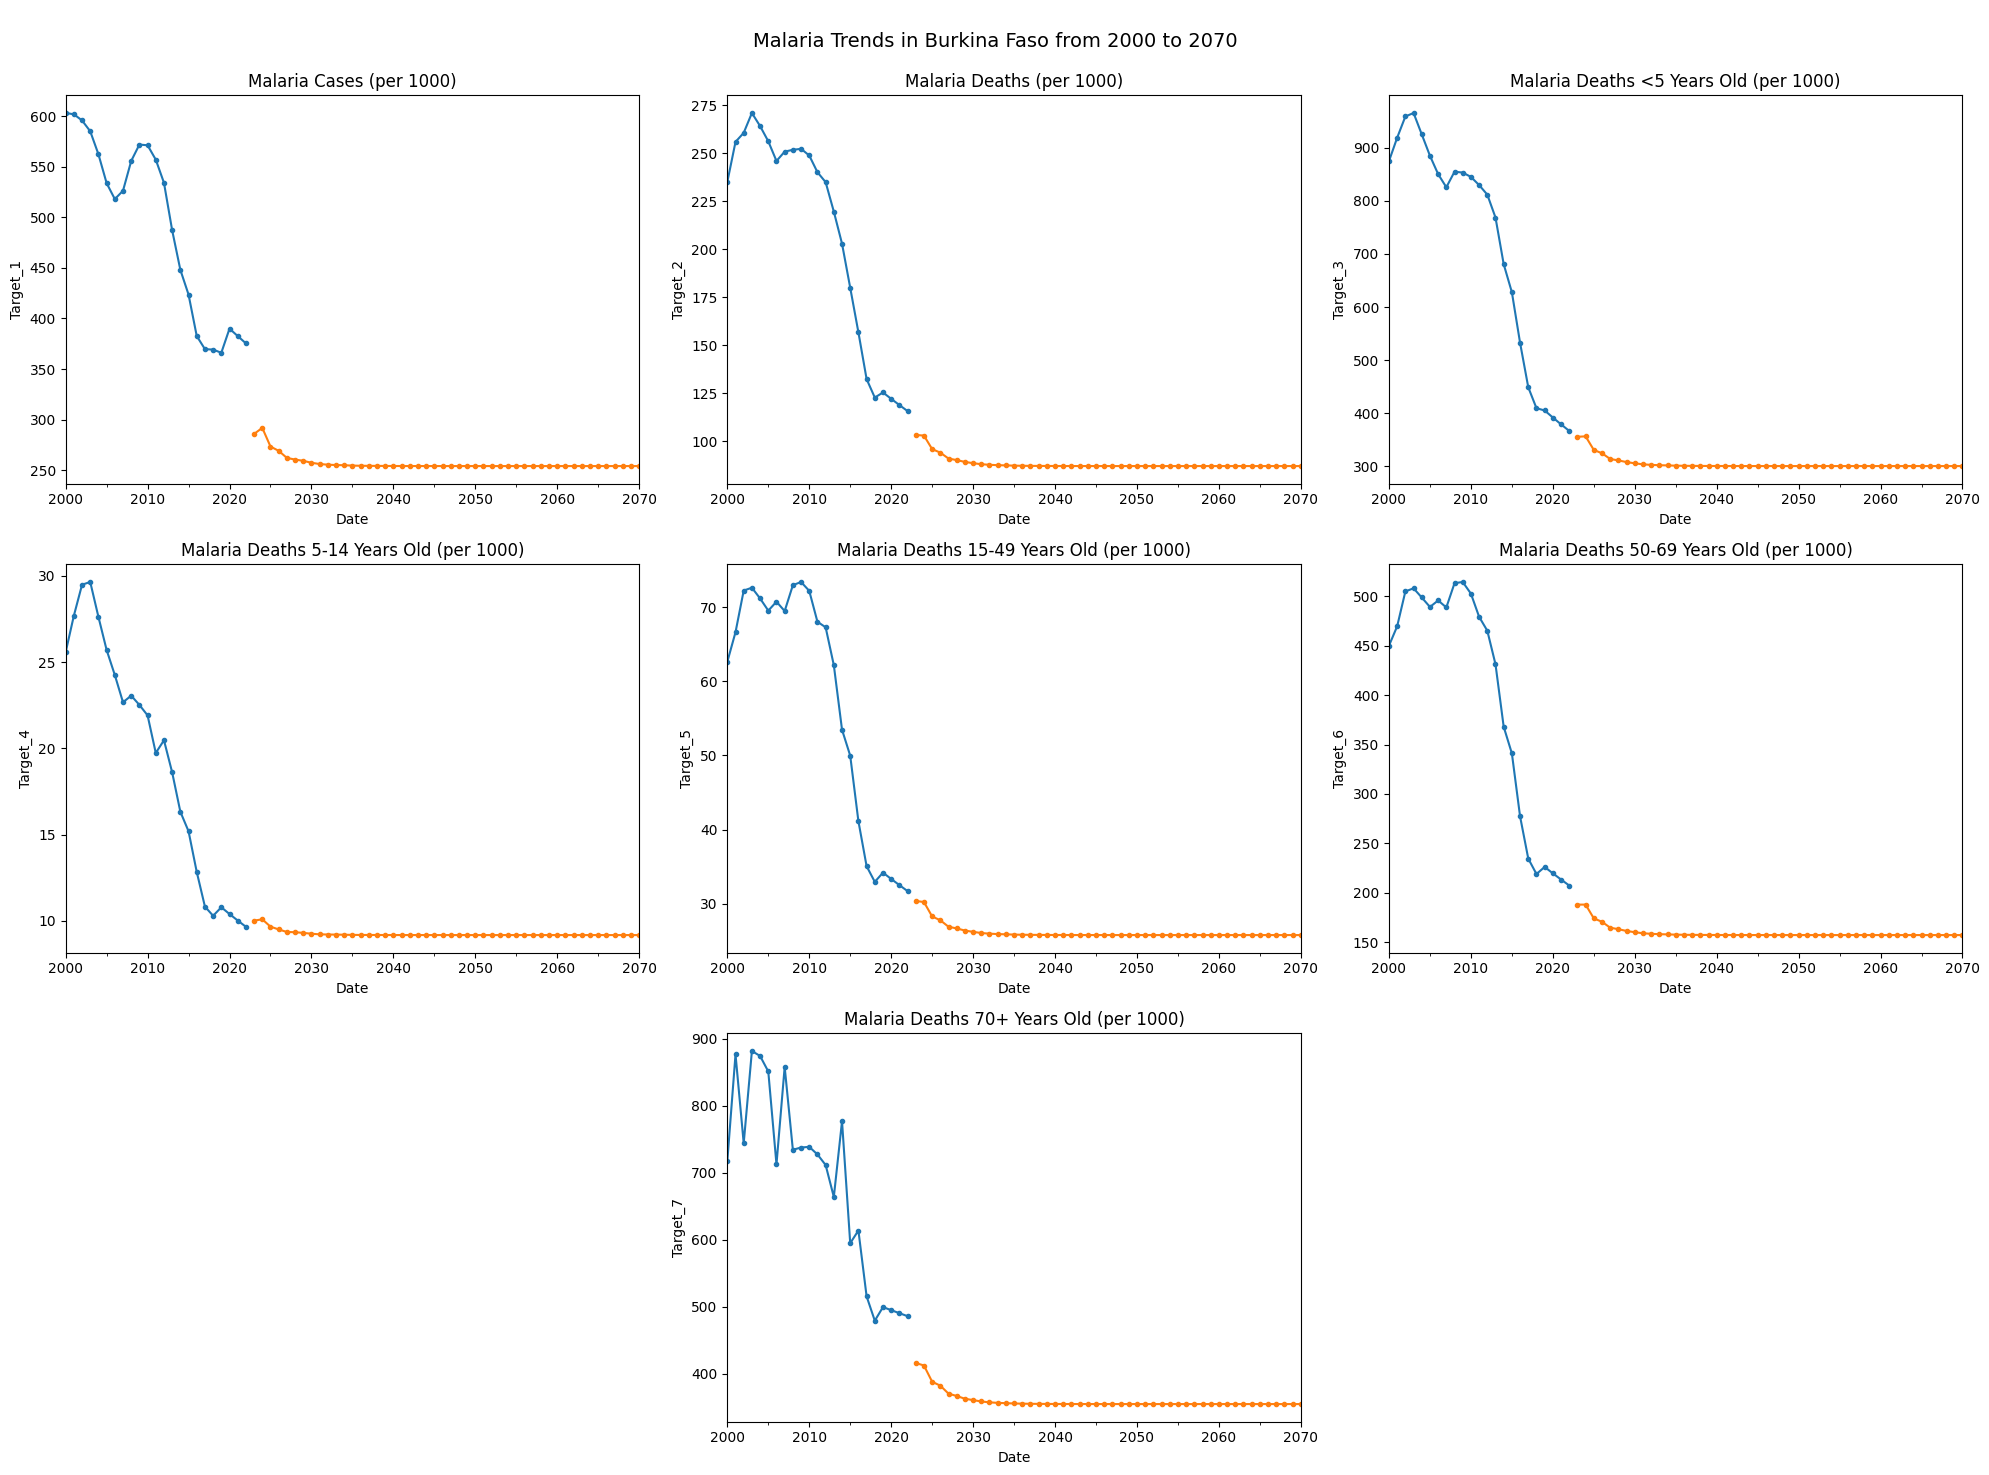

In [21]:
plotmaker.serve_country_predictions(
    data=bfa_pred, 
    country="Burkina Faso",
    targets_list = list(targets_dict.keys()) ,
    target_names = list(targets_dict.values()),
    nrows=3,
    ncols=3, 
    figsize=(20, 15), 
    nfigs=7, 
    centered=True
)

In [22]:
bfa_pred[bfa_pred["Predicted"] == 1][target_columns].min()

Target_1    254.030640
Target_2     87.022797
Target_3    300.643890
Target_4      9.173012
Target_5     25.797369
Target_6    157.101425
Target_7    354.492920
dtype: float64

### Ghana

In [23]:
gha_pred = predict_to_2070(
    model=model,
    data=gha, 
    seq_length=2, 
    scaler_inputs=scaler_inputs,
    scaler_targets=scaler_targets,
    input_columns=input_columns,
    target_columns=target_columns,
    feature_columns=feature_columns
)

1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 41ms/step


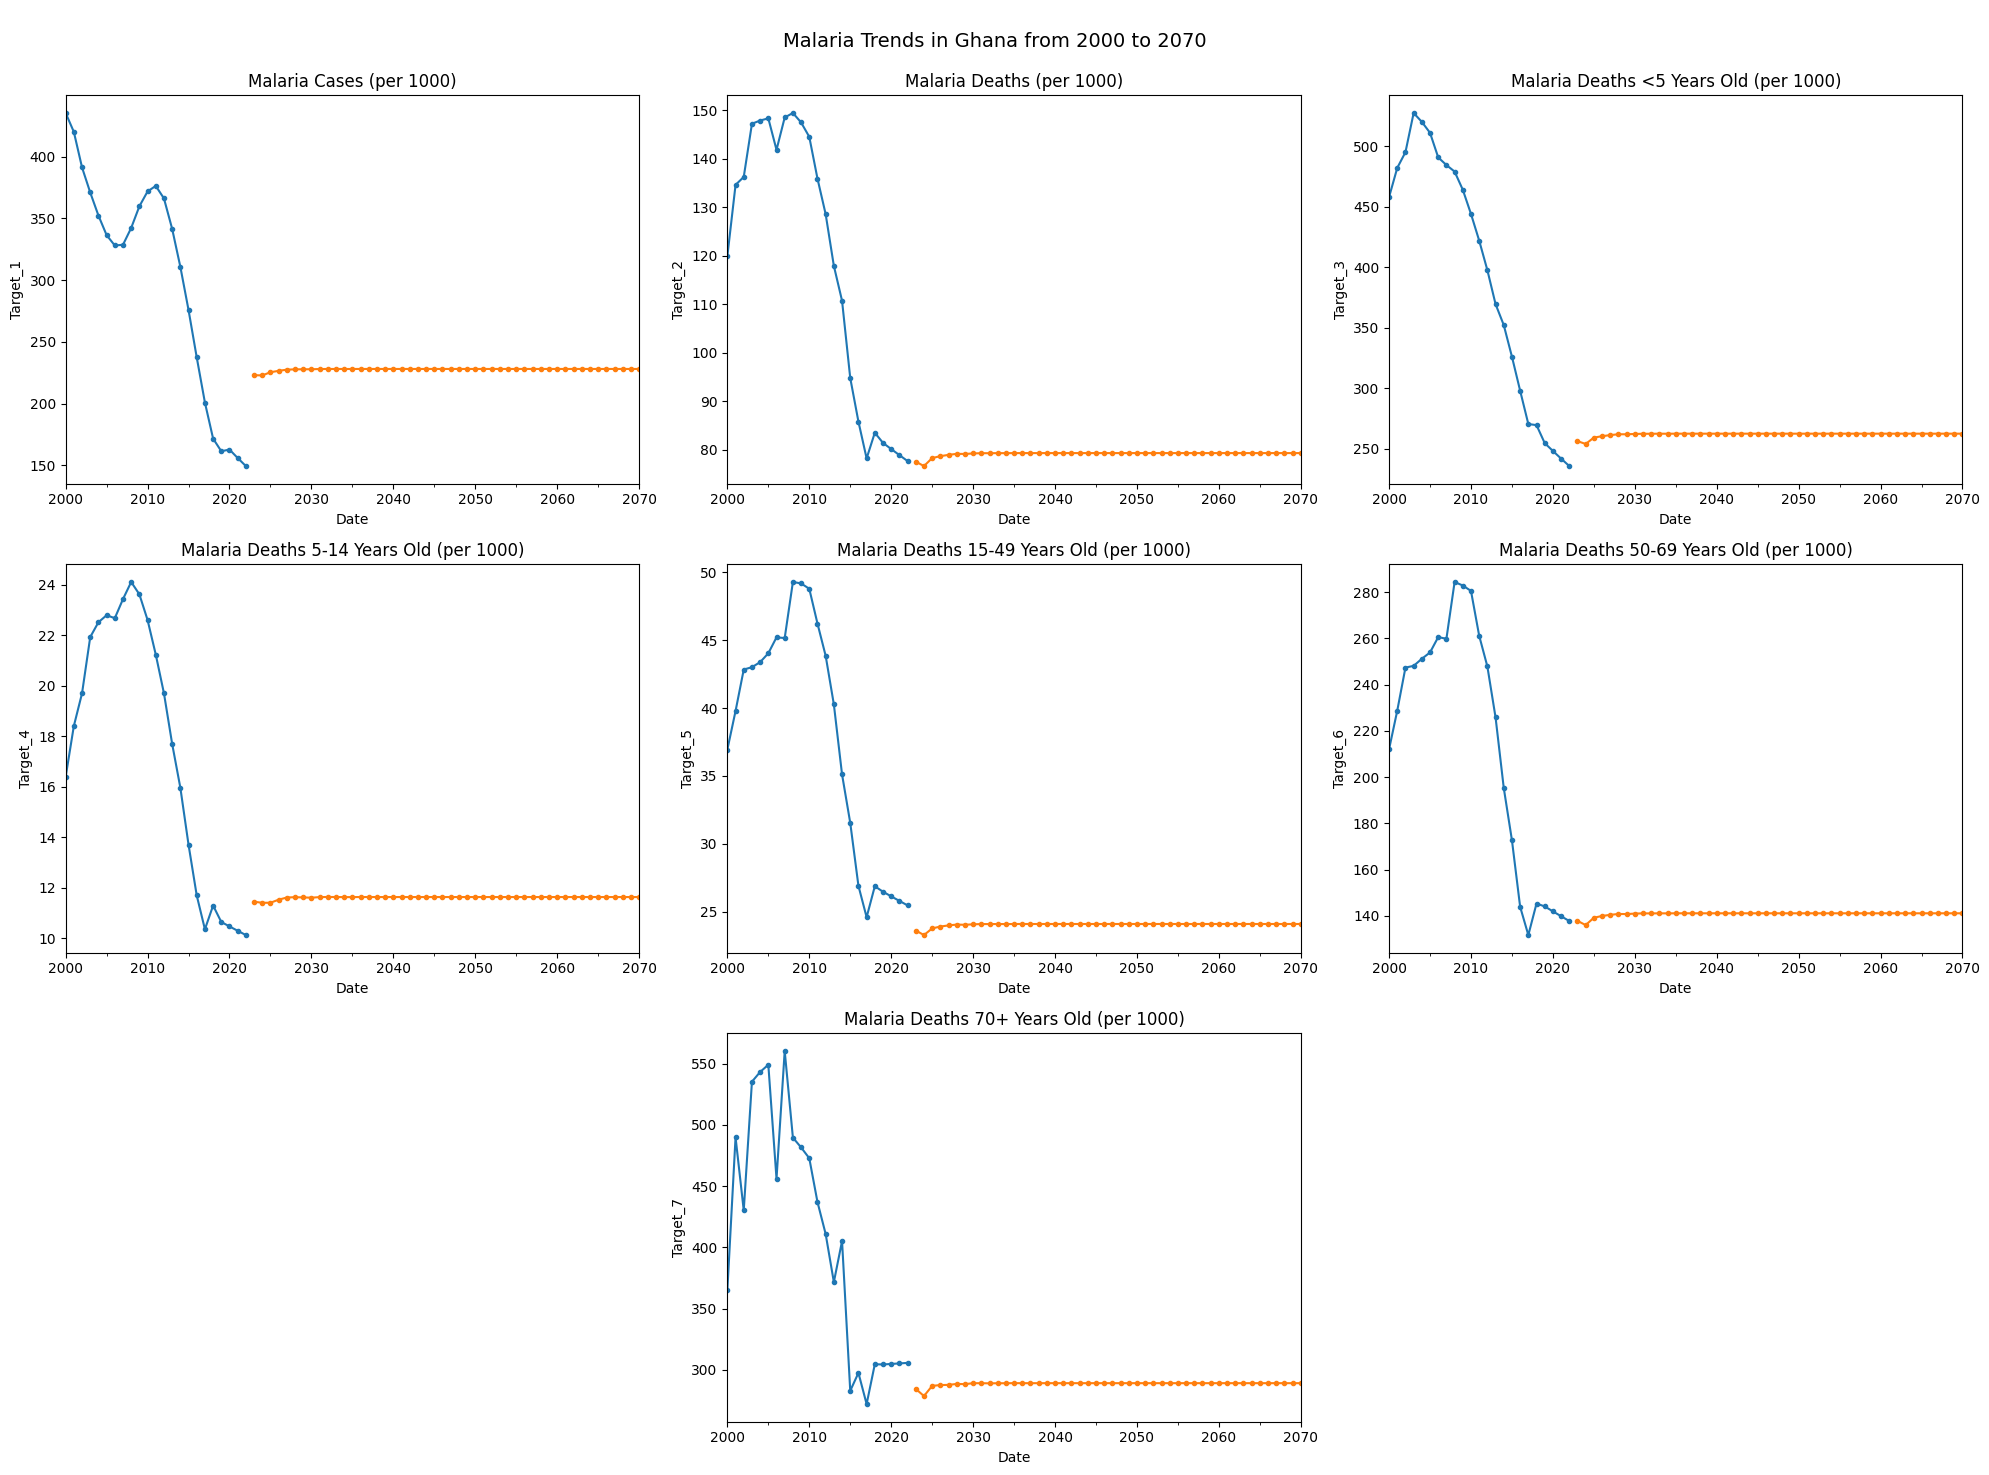

In [24]:
plotmaker.serve_country_predictions(
    data=gha_pred, 
    country="Ghana",
    targets_list = list(targets_dict.keys()) ,
    target_names = list(targets_dict.values()),
    nrows=3,
    ncols=3, 
    figsize=(20, 15), 
    nfigs=7, 
    centered=True
)

In [25]:
gha_pred[gha_pred["Predicted"] == 1][target_columns].min()

Target_1    222.863892
Target_2     76.610741
Target_3    253.955750
Target_4     11.402372
Target_5     23.266212
Target_6    136.059677
Target_7    278.502228
dtype: float64

### Kenya

In [26]:
ken_pred = predict_to_2070(
    model=model,
    data=ken, 
    seq_length=2, 
    scaler_inputs=scaler_inputs,
    scaler_targets=scaler_targets,
    input_columns=input_columns,
    target_columns=target_columns,
    feature_columns=feature_columns
)

1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 40ms/step


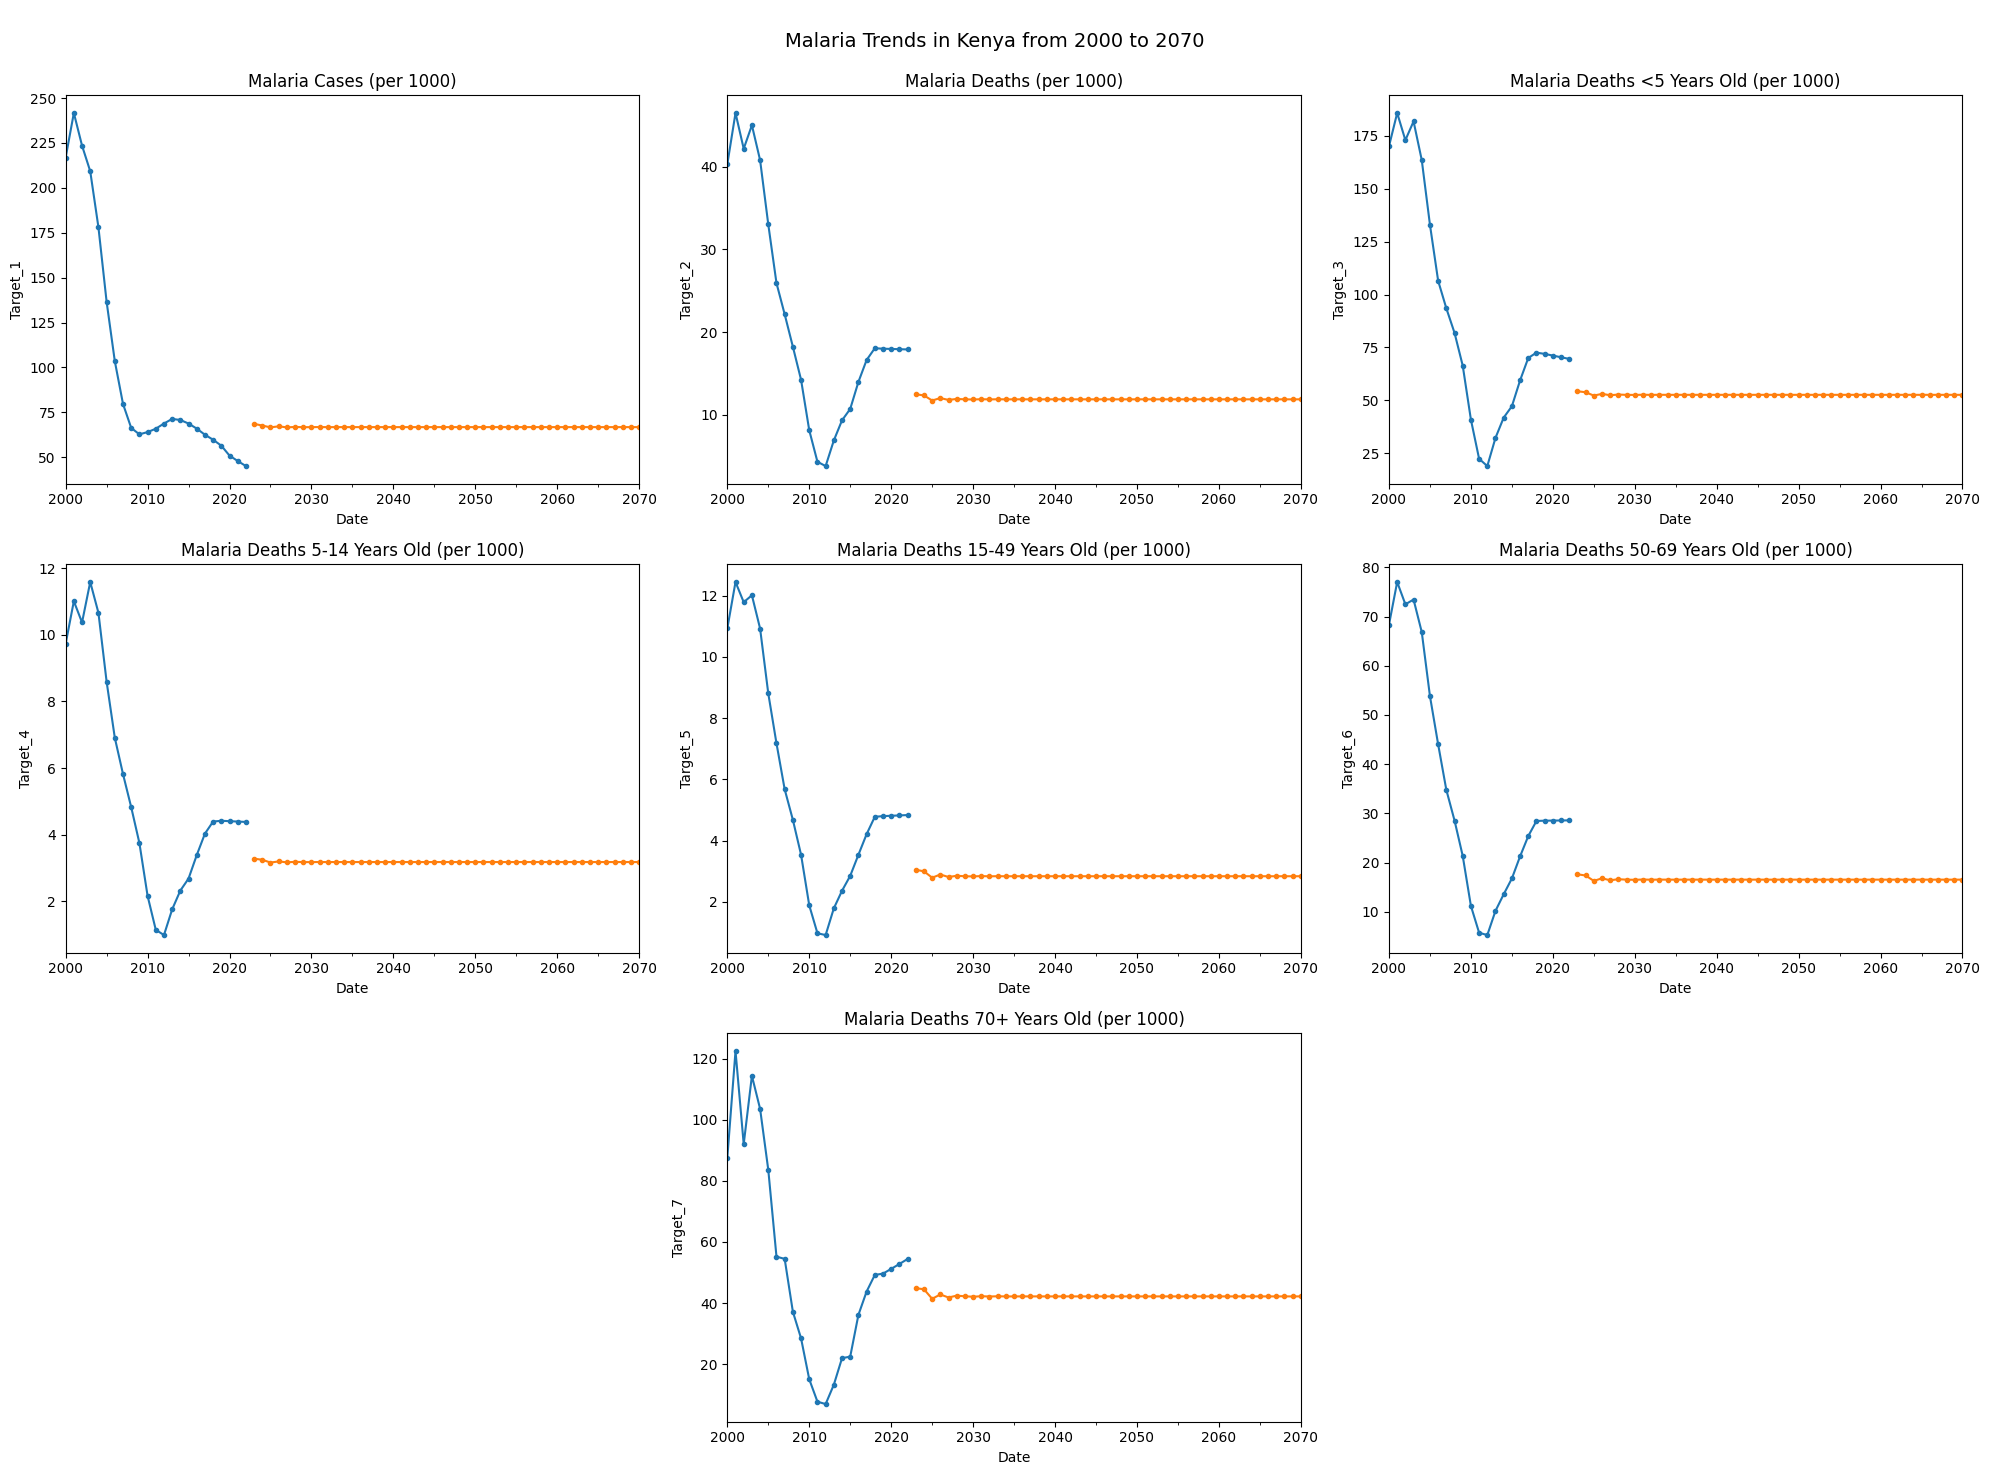

In [27]:
plotmaker.serve_country_predictions(
    data=ken_pred, 
    country="Kenya",
    targets_list = list(targets_dict.keys()) ,
    target_names = list(targets_dict.values()),
    nrows=3,
    ncols=3, 
    figsize=(20, 15), 
    nfigs=7, 
    centered=True
)

In [28]:
ken_pred[ken_pred["Predicted"] == 1][target_columns].min()

Target_1    66.642868
Target_2    11.732491
Target_3    52.266716
Target_4     3.164427
Target_5     2.785922
Target_6    16.267960
Target_7    41.394463
dtype: float64

### Malawi

In [29]:
mwi_pred = predict_to_2070(
    model=model,
    data=mwi, 
    seq_length=2, 
    scaler_inputs=scaler_inputs,
    scaler_targets=scaler_targets,
    input_columns=input_columns,
    target_columns=target_columns,
    feature_columns=feature_columns
)

1/1 [==============================] - 0s 34ms/step


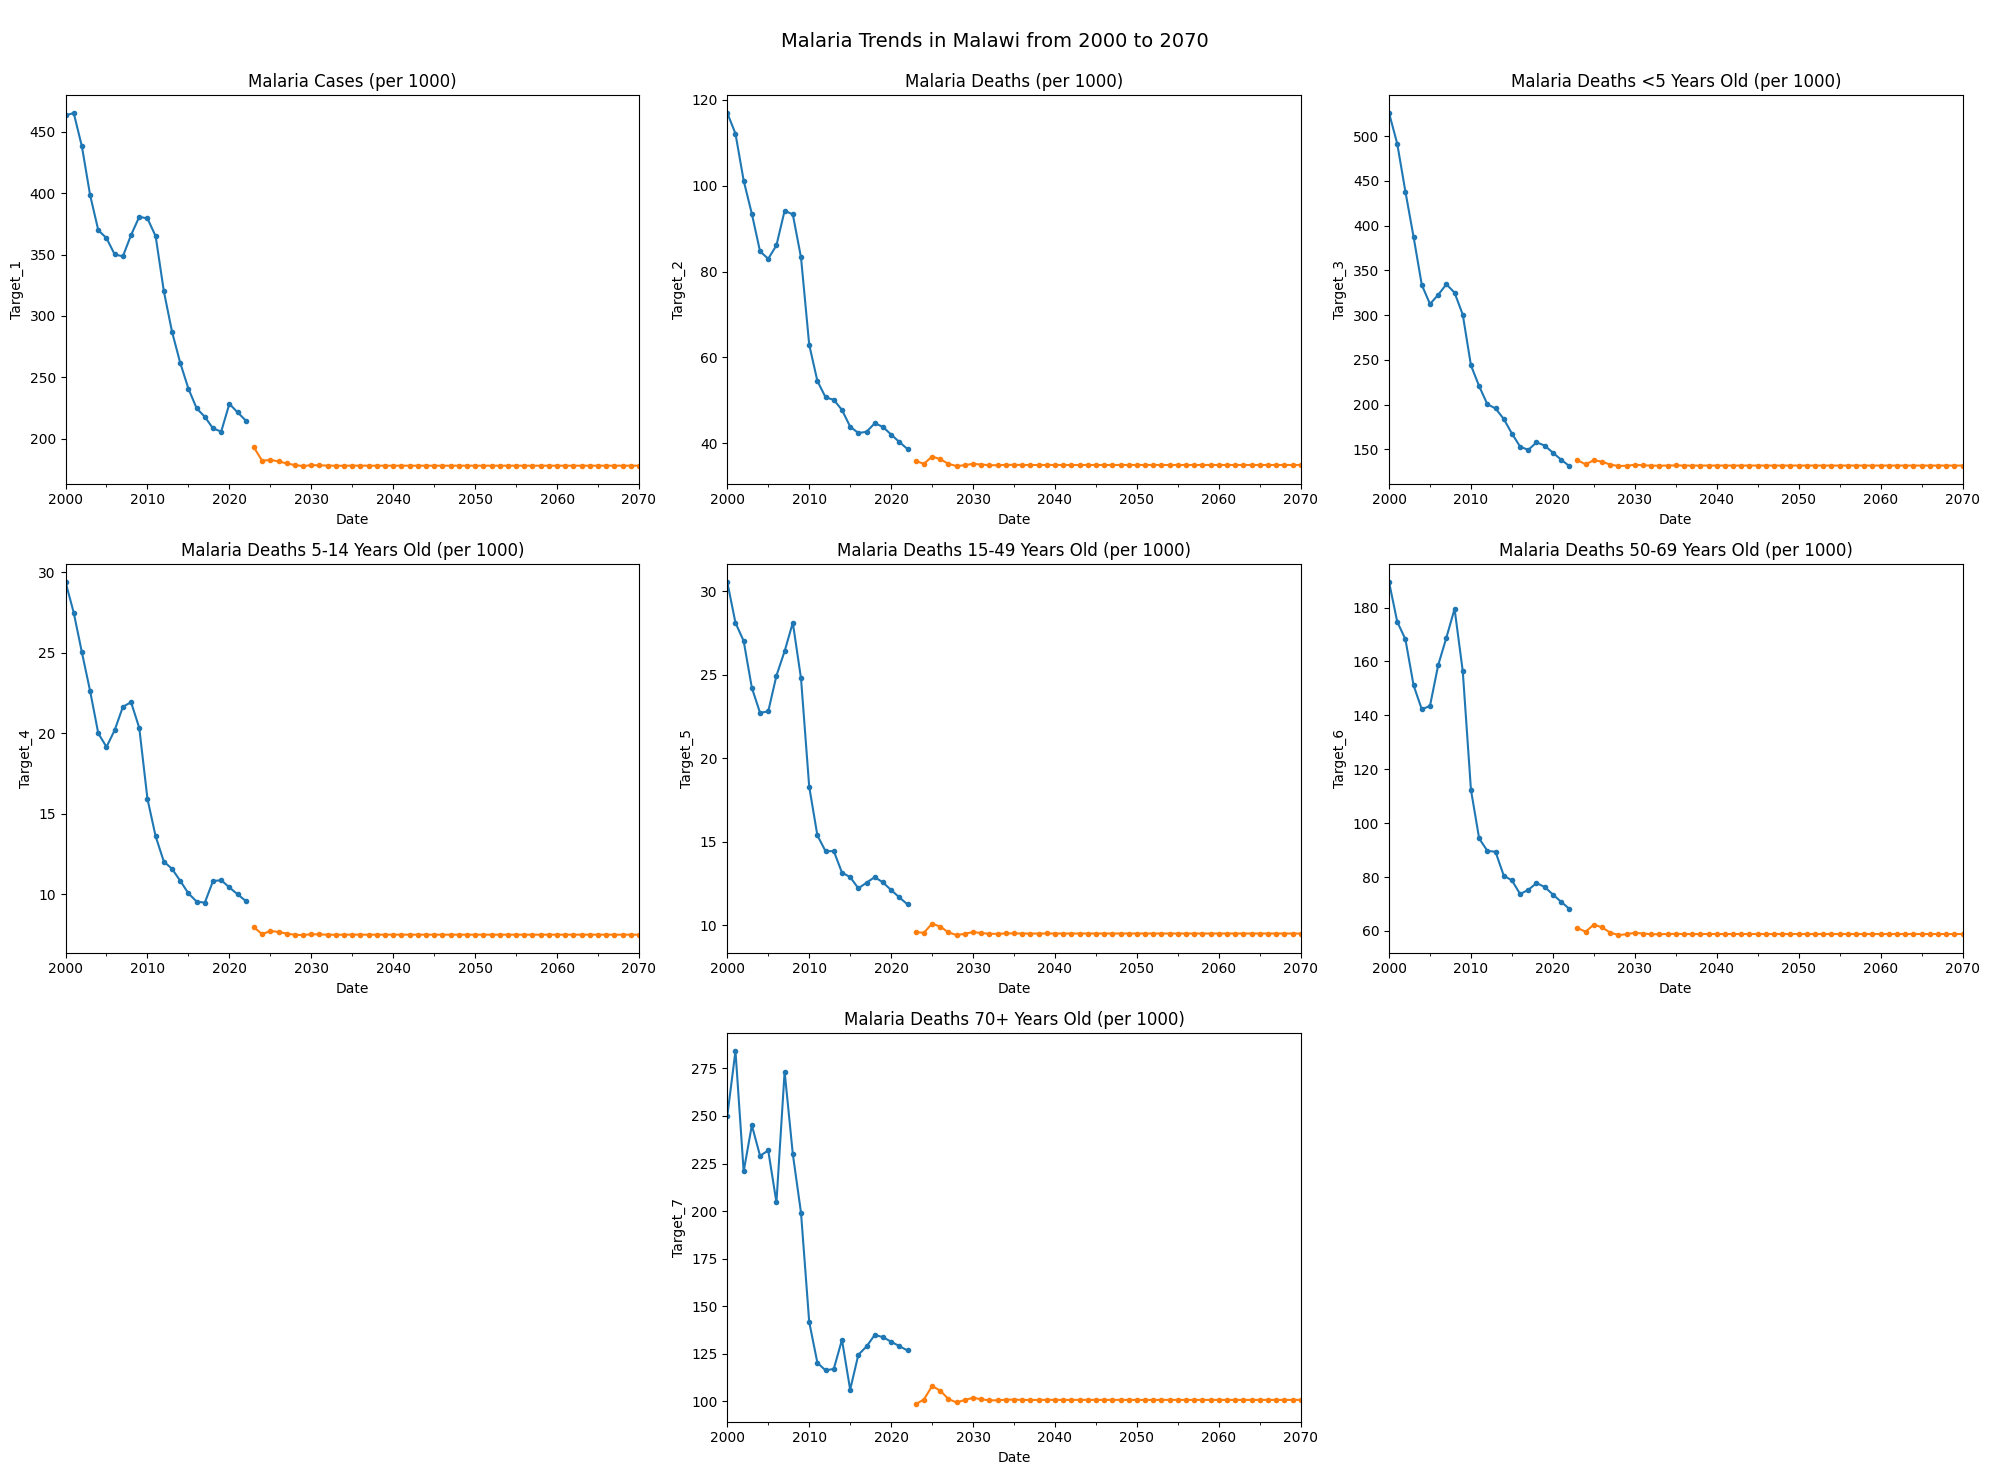

In [30]:
plotmaker.serve_country_predictions(
    data=mwi_pred, 
    country="Malawi",
    targets_list = list(targets_dict.keys()) ,
    target_names = list(targets_dict.values()),
    nrows=3,
    ncols=3, 
    figsize=(20, 15), 
    nfigs=7, 
    centered=True
)

In [31]:
mwi_pred[mwi_pred["Predicted"] == 1][target_columns].min()

Target_1    177.804871
Target_2     34.686371
Target_3    131.405838
Target_4      7.471449
Target_5      9.424596
Target_6     58.474060
Target_7     98.610497
dtype: float64

### Nigeria

In [32]:
nga_pred = predict_to_2070(
    model=model,
    data=nga, 
    seq_length=2, 
    scaler_inputs=scaler_inputs,
    scaler_targets=scaler_targets,
    input_columns=input_columns,
    target_columns=target_columns,
    feature_columns=feature_columns
)

1/1 [==============================] - 0s 59ms/step


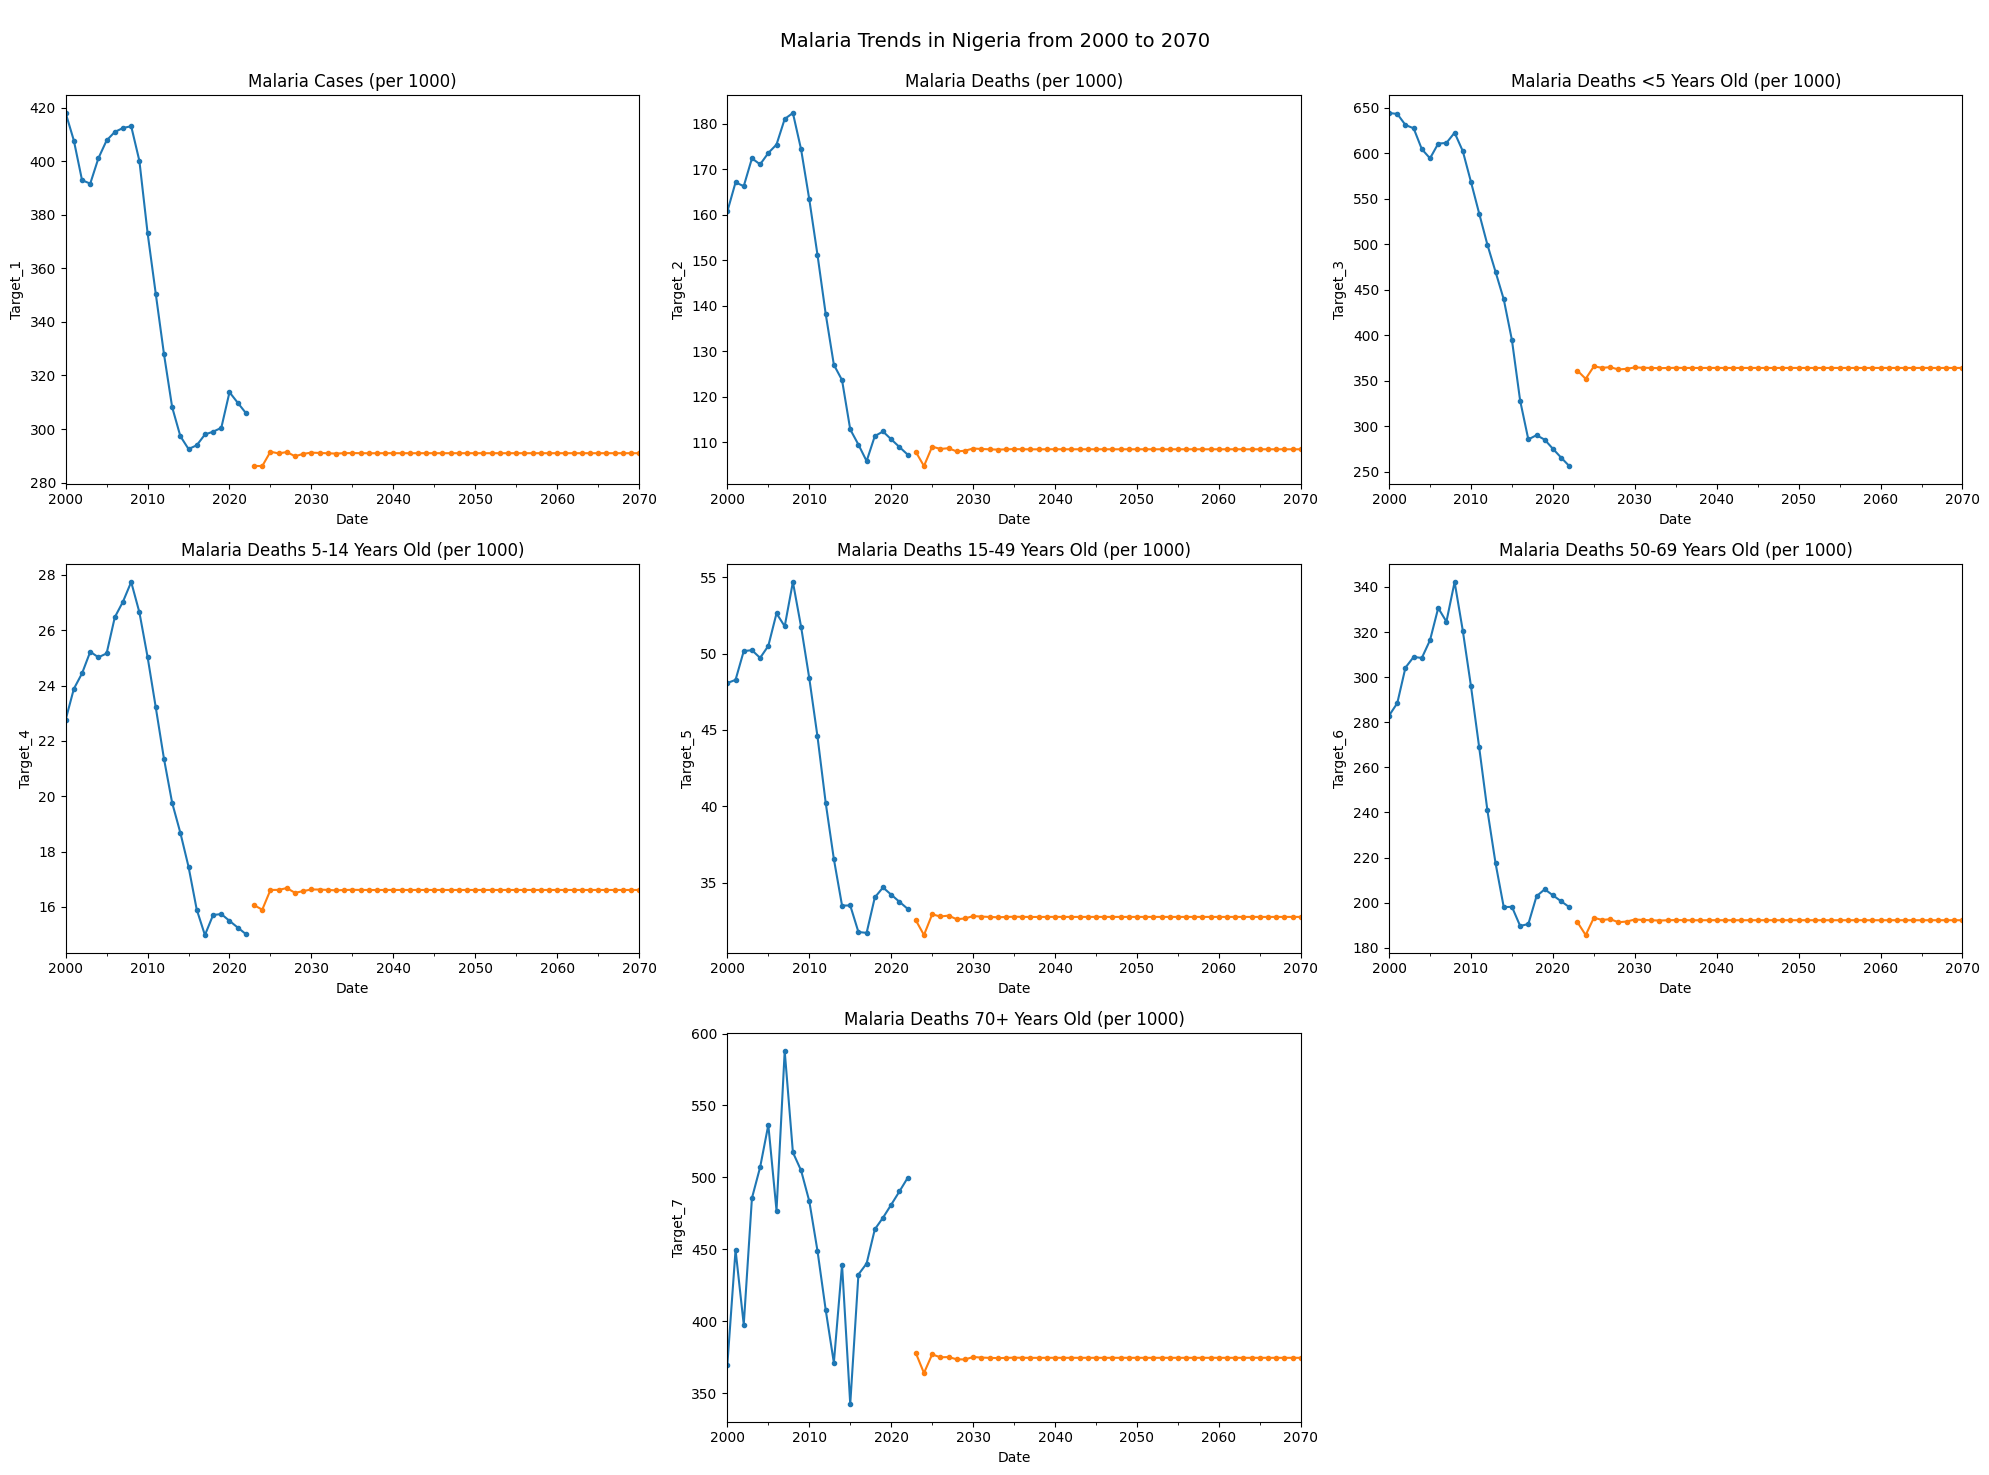

In [33]:
plotmaker.serve_country_predictions(
    data=nga_pred, 
    country="Nigeria",
    targets_list = list(targets_dict.keys()) ,
    target_names = list(targets_dict.values()),
    nrows=3,
    ncols=3, 
    figsize=(20, 15), 
    nfigs=7, 
    centered=True
)

In [34]:
nga_pred[nga_pred["Predicted"] == 1][target_columns].min()

Target_1    286.170319
Target_2    104.740822
Target_3    352.156708
Target_4     15.897136
Target_5     31.583221
Target_6    185.640579
Target_7    364.058289
dtype: float64

### Further predictions in Nigeria

### Case 1 - Nigeria’s participation in R21 vaccine trial programs from 2023

In [35]:
vaccine_features = {
    "Feature_32": 0,
    "Feature_33": 0,
    "Feature_34": 1
}

In [36]:
nga_pred_case1 = predict_to_2070(
    model=model,
    data=nga,
    vaccine_features=vaccine_features,
    seq_length=2, 
    scaler_inputs=scaler_inputs,
    scaler_targets=scaler_targets,
    input_columns=input_columns,
    target_columns=target_columns,
    feature_columns=feature_columns
)

1/1 [==============================] - 0s 44ms/step


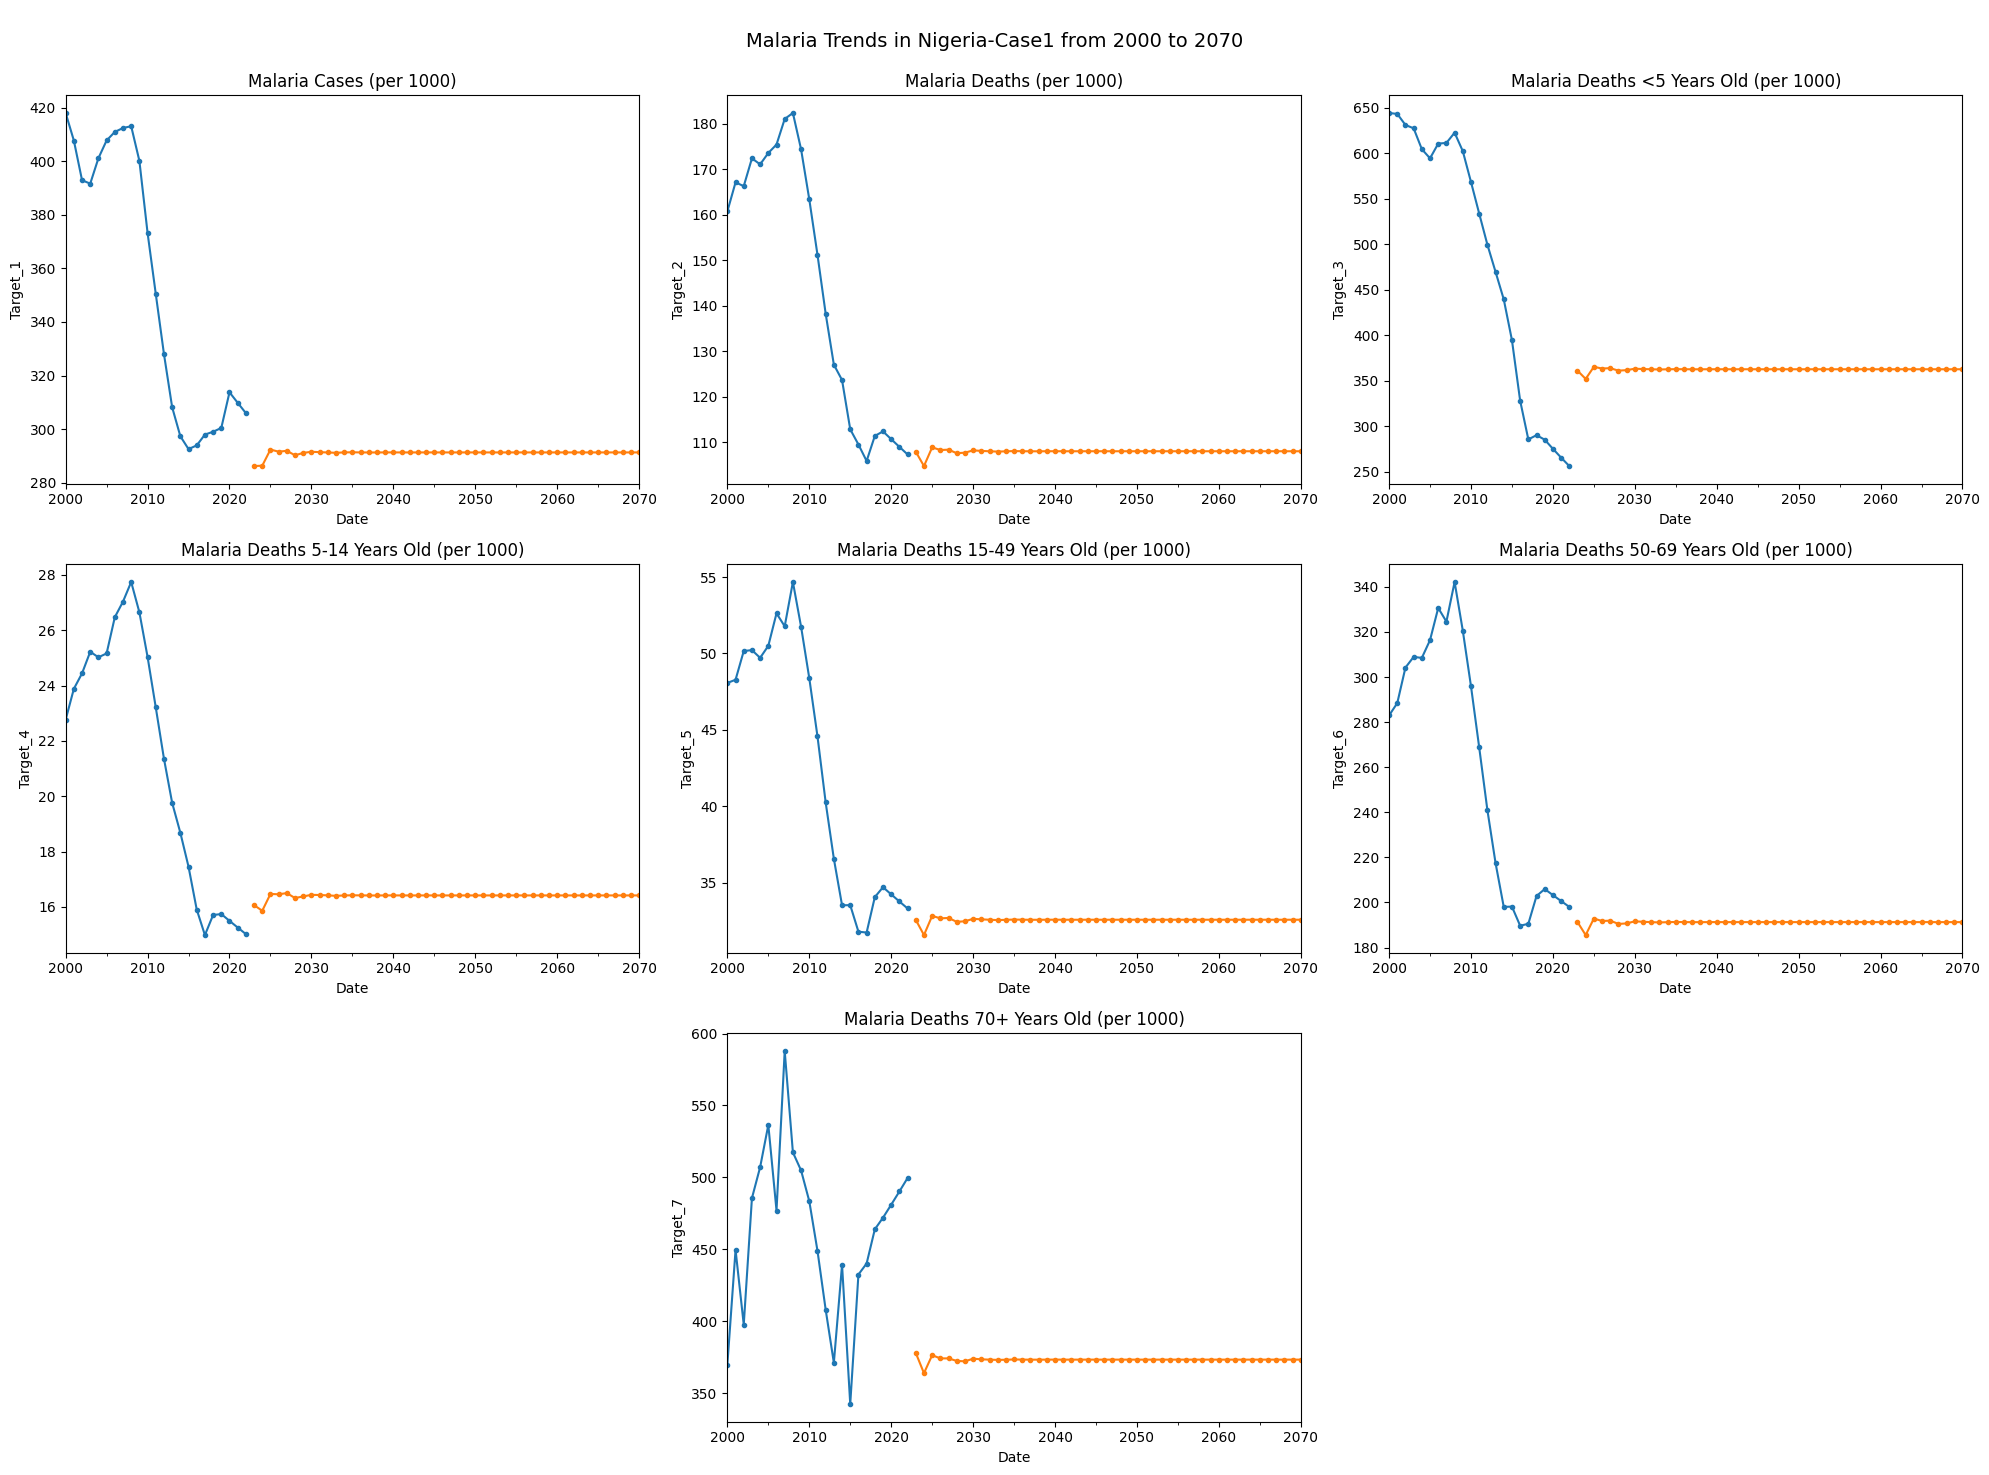

In [37]:
plotmaker.serve_country_predictions(
    data=nga_pred_case1, 
    country="Nigeria-Case1",
    targets_list = list(targets_dict.keys()) ,
    target_names = list(targets_dict.values()),
    nrows=3,
    ncols=3, 
    figsize=(20, 15), 
    nfigs=7, 
    centered=True
)

In [38]:
nga_pred_case1[nga_pred_case1["Predicted"] == 1][target_columns].min()

Target_1    286.205353
Target_2    104.714722
Target_3    352.075500
Target_4     15.859166
Target_5     31.561476
Target_6    185.532623
Target_7    363.973907
dtype: float64

### Case 2 - Nigeria’s participation in RTS vaccine trial programs by officially implementing the MVIP program from 2023.

In [39]:
vaccine_features = {
    "Feature_32": 1,
    "Feature_33": 1,
    "Feature_34": 0
}

In [40]:
nga_pred_case2 = predict_to_2070(
    model=model,
    data=nga,
    vaccine_features=vaccine_features,
    seq_length=2, 
    scaler_inputs=scaler_inputs,
    scaler_targets=scaler_targets,
    input_columns=input_columns,
    target_columns=target_columns,
    feature_columns=feature_columns
)

1/1 [==============================] - 0s 33ms/step


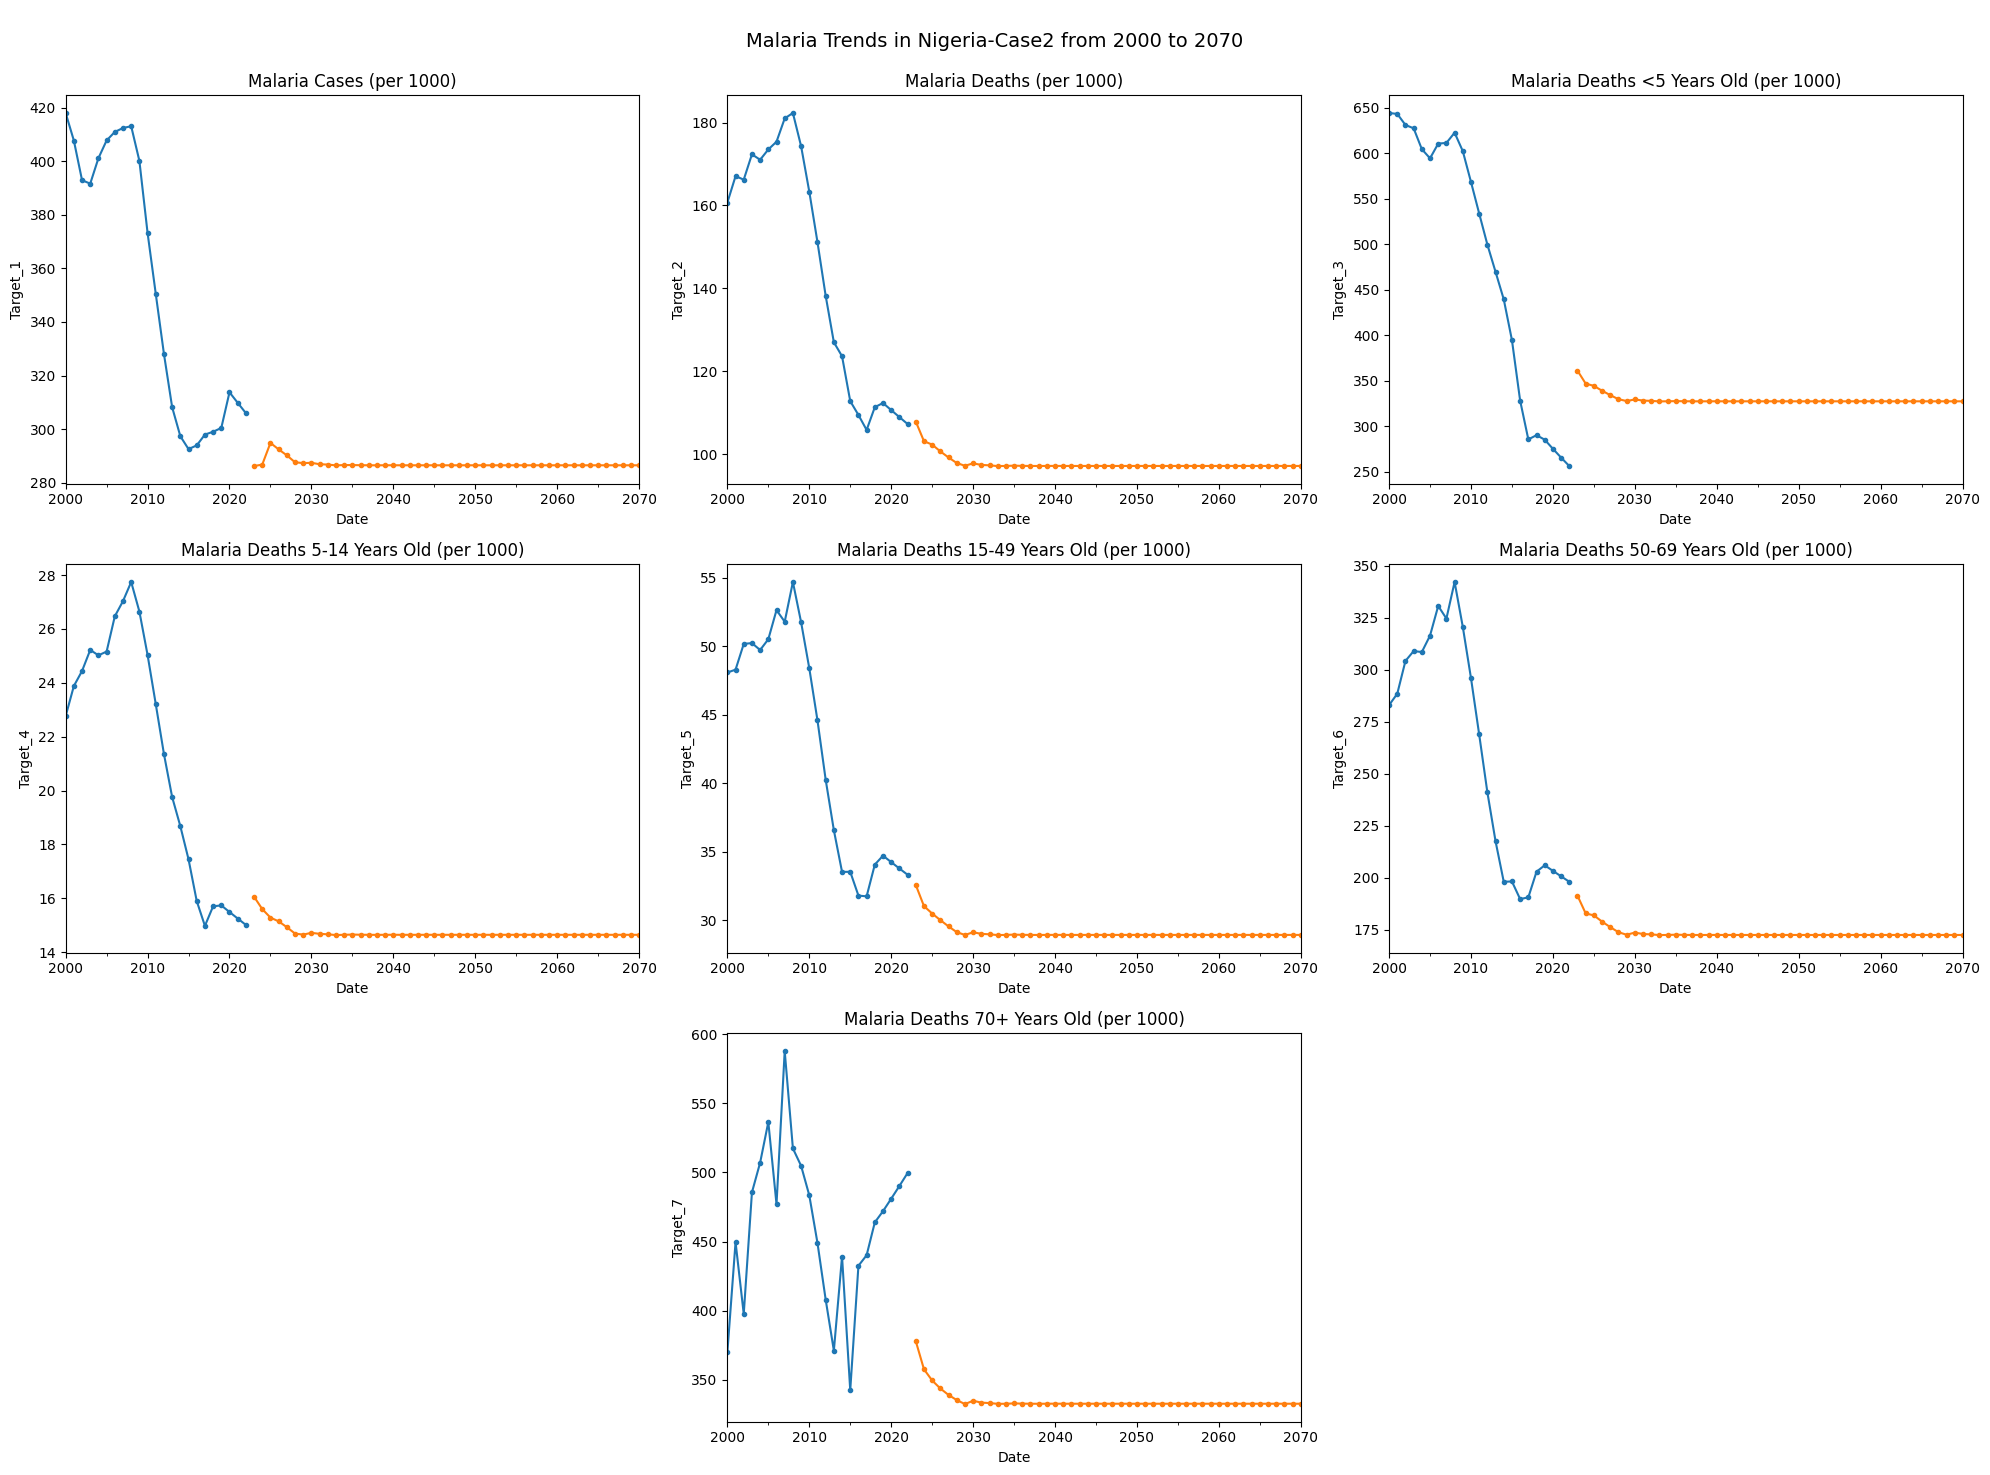

In [41]:
plotmaker.serve_country_predictions(
    data=nga_pred_case2, 
    country="Nigeria-Case2",
    targets_list = list(targets_dict.keys()) ,
    target_names = list(targets_dict.values()),
    nrows=3,
    ncols=3, 
    figsize=(20, 15), 
    nfigs=7, 
    centered=True
)

In [42]:
nga_pred_case2[nga_pred_case2["Predicted"] == 1][target_columns].min()

Target_1    286.205353
Target_2     97.119713
Target_3    327.365448
Target_4     14.638778
Target_5     28.900244
Target_6    172.389221
Target_7    332.543304
dtype: float64